In [119]:
import os
import sys
import re

import time
import random
import warnings

import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import make_scorer

from matplotlib import pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

pd.options.display.max_columns = 1000
pd.options.display.max_rows = 10000
pd.options.display.max_colwidth = -1

def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

RANDOM_STATE = 313
seed_everything(seed=RANDOM_STATE)

sns.set()

In [120]:
covid = pd.read_csv('D:\\corona_data\\covid_19_data.csv')

In [121]:
covid.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [122]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29426 entries, 0 to 29425
Data columns (total 8 columns):
SNo                29426 non-null int64
ObservationDate    29426 non-null object
Province/State     14527 non-null object
Country/Region     29426 non-null object
Last Update        29426 non-null object
Confirmed          29426 non-null float64
Deaths             29426 non-null float64
Recovered          29426 non-null float64
dtypes: float64(3), int64(1), object(4)
memory usage: 1.8+ MB


In [123]:
covid.describe(include='all')

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
count,29426.000000,29426,14527,29426,29426,29426.000000,29426.000000,29426.000000
unique,NaN,125,429,223,1866,NaN,NaN,NaN
top,NaN,05/23/2020,Diamond Princess cruise ship,US,3/8/20 5:31,NaN,NaN,NaN
freq,NaN,452,187,5338,1232,NaN,NaN,NaN
mean,14713.500000,NaN,NaN,NaN,NaN,6237.239754,408.005573,2003.861755
std,8494.698847,NaN,NaN,NaN,NaN,24551.983717,2289.689879,12326.847623
min,1.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
25%,7357.250000,NaN,NaN,NaN,NaN,20.000000,0.000000,0.000000
50%,14713.500000,NaN,NaN,NaN,NaN,252.000000,3.000000,10.000000
75%,22069.750000,NaN,NaN,NaN,NaN,1642.750000,42.000000,251.750000


In [124]:
covid.dtypes

SNo                int64  
ObservationDate    object 
Province/State     object 
Country/Region     object 
Last Update        object 
Confirmed          float64
Deaths             float64
Recovered          float64
dtype: object

In [125]:
covid.isnull().sum()

SNo                0    
ObservationDate    0    
Province/State     14899
Country/Region     0    
Last Update        0    
Confirmed          0    
Deaths             0    
Recovered          0    
dtype: int64

In [126]:
# making column names more proper
cols = covid.columns
covid.columns = [col.lower() for col in cols]

covid.rename(columns={'observationdate' : 'observation_date', 
                      'country/region'  : 'country',
                      'province/state'  : 'province',
                      'last update'     : 'last_update'}, inplace=True)
covid.head()

,sno,observation_date,province,country,last_update,confirmed,deaths,recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [127]:
covid.country.unique()

array(['Mainland China', 'Hong Kong', 'Macau', 'Taiwan', 'US', 'Japan',
       'Thailand', 'South Korea', 'Singapore', 'Philippines', 'Malaysia',
       'Vietnam', 'Australia', 'Mexico', 'Brazil', 'Colombia', 'France',
       'Nepal', 'Canada', 'Cambodia', 'Sri Lanka', 'Ivory Coast',
       'Germany', 'Finland', 'United Arab Emirates', 'India', 'Italy',
       'UK', 'Russia', 'Sweden', 'Spain', 'Belgium', 'Others', 'Egypt',
       'Iran', 'Israel', 'Lebanon', 'Iraq', 'Oman', 'Afghanistan',
       'Bahrain', 'Kuwait', 'Austria', 'Algeria', 'Croatia',
       'Switzerland', 'Pakistan', 'Georgia', 'Greece', 'North Macedonia',
       'Norway', 'Romania', 'Denmark', 'Estonia', 'Netherlands',
       'San Marino', ' Azerbaijan', 'Belarus', 'Iceland', 'Lithuania',
       'New Zealand', 'Nigeria', 'North Ireland', 'Ireland', 'Luxembourg',
       'Monaco', 'Qatar', 'Ecuador', 'Azerbaijan', 'Czech Republic',
       'Armenia', 'Dominican Republic', 'Indonesia', 'Portugal',
       'Andorra', 'Latvia

In [128]:
sorted(covid.country.unique())

[' Azerbaijan',
 "('St. Martin',)",
 'Afghanistan',
 'Albania',
 'Algeria',
 'Andorra',
 'Angola',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Aruba',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahamas, The',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Burma',
 'Burundi',
 'Cabo Verde',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cape Verde',
 'Cayman Islands',
 'Central African Republic',
 'Chad',
 'Channel Islands',
 'Chile',
 'Colombia',
 'Comoros',
 'Congo (Brazzaville)',
 'Congo (Kinshasa)',
 'Costa Rica',
 'Croatia',
 'Cuba',
 'Curacao',
 'Cyprus',
 'Czech Republic',
 'Denmark',
 'Diamond Princess',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'East Timor',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Eswatini',
 'Ethiopia',
 'Faroe Islands',
 'Fiji',
 'Finland',
 

In [129]:
# Handle country names
def clean_country(country):
    country = country.lower().strip()
    country = re.sub(r'[^a-z\s]+', '', country)
    country = 'China' if country == 'Mainland China' else country
    return country

covid['country'] = covid['country'].apply(lambda country: clean_country(country))

In [130]:
sorted(covid.country.unique())

['afghanistan',
 'albania',
 'algeria',
 'andorra',
 'angola',
 'antigua and barbuda',
 'argentina',
 'armenia',
 'aruba',
 'australia',
 'austria',
 'azerbaijan',
 'bahamas',
 'bahamas the',
 'bahrain',
 'bangladesh',
 'barbados',
 'belarus',
 'belgium',
 'belize',
 'benin',
 'bhutan',
 'bolivia',
 'bosnia and herzegovina',
 'botswana',
 'brazil',
 'brunei',
 'bulgaria',
 'burkina faso',
 'burma',
 'burundi',
 'cabo verde',
 'cambodia',
 'cameroon',
 'canada',
 'cape verde',
 'cayman islands',
 'central african republic',
 'chad',
 'channel islands',
 'chile',
 'colombia',
 'comoros',
 'congo brazzaville',
 'congo kinshasa',
 'costa rica',
 'croatia',
 'cuba',
 'curacao',
 'cyprus',
 'czech republic',
 'denmark',
 'diamond princess',
 'djibouti',
 'dominica',
 'dominican republic',
 'east timor',
 'ecuador',
 'egypt',
 'el salvador',
 'equatorial guinea',
 'eritrea',
 'estonia',
 'eswatini',
 'ethiopia',
 'faroe islands',
 'fiji',
 'finland',
 'france',
 'french guiana',
 'gabon',
 'g

In [131]:
# Check if the number of cases per country increases monotonically as time passes by, if not, fix it
def check_monotonic_increasing(grp):
    if np.sum(np.diff(grp) < 0) > 0:
        return False
    else:
        return True
    
def force_monotonic_increasing(grp):
    if np.sum(np.diff(grp) < 0) > 0:
        return sorted(grp)
    else:
        return grp

In [132]:
# Check if the number of cases per country increases monotonically as time passes by, if not, fix it
def is_sorted(a):
    b = np.sort(a)
    if all(a==b):
        return True
    else:
        return False
    
def make_sorted(a):
    if is_sorted(a)==False:
        return np.sort(a)
    else:
        return a

In [133]:
import time
start = time.time()
monitor = country_scores.groupby(by=['country']).transform(lambda grp: is_sorted(grp))
end = time.time()
print(end - start)

start = time.time()
monitor = country_scores.groupby(by=['country']).transform(lambda grp: check_monotonic_increasing(grp))
end = time.time()
print(end - start)

1.3890793323516846
0.9870562553405762


In [134]:
group_country_date = covid.groupby(by=['country', 'observation_date']).agg({'confirmed': 'sum', 'deaths': 'sum', 'recovered': 'sum'}).sort_values(by=['country', 'observation_date'], ascending=[True, True])
group_country = group_country_date.reset_index(level=1, drop=True)
country_date_scores = group_country_date.reset_index()
country_scores = group_country.reset_index()

In [135]:
country_scores.head()

,country,confirmed,deaths,recovered
0,afghanistan,1.0,0.0,0.0
1,afghanistan,1.0,0.0,0.0
2,afghanistan,1.0,0.0,0.0
3,afghanistan,1.0,0.0,0.0
4,afghanistan,1.0,0.0,0.0


In [136]:
monitor = country_scores.groupby(by=['country']).transform(lambda grp: check_monotonic_increasing(grp))
monitor = monitor.apply(lambda x: x['confirmed'] and x['deaths'] and x['recovered'], axis=1)
non_monotonic_increase = country_scores.iloc[np.where(monitor == False)]
print("There are {} country in which disease cases do not increase monotonically".format(non_monotonic_increase.country.nunique()))
print(non_monotonic_increase.country.unique())
non_monotonic_increase


There are 82 country in which disease cases do not increase monotonically
['algeria' 'andorra' 'australia' 'austria' 'azerbaijan' 'bahamas'
 'bahrain' 'belarus' 'belgium' 'benin' 'cambodia' 'cameroon' 'canada'
 'cyprus' 'czech republic' 'denmark' 'ecuador' 'egypt' 'estonia'
 'ethiopia' 'finland' 'france' 'germany' 'ghana' 'greenland' 'guam'
 'guernsey' 'guyana' 'haiti' 'honduras' 'hong kong' 'iceland' 'india'
 'iraq' 'ireland' 'italy' 'japan' 'jersey' 'kazakhstan' 'laos' 'latvia'
 'lebanon' 'libya' 'lithuania' 'luxembourg' 'madagascar' 'mainland china'
 'malta' 'mauritius' 'montenegro' 'nepal' 'netherlands' 'new zealand'
 'occupied palestinian territory' 'others' 'philippines' 'poland'
 'portugal' 'puerto rico' 'republic of the congo' 'russia'
 'saint barthelemy' 'san marino' 'serbia' 'slovakia' 'south korea' 'spain'
 'sri lanka' 'tajikistan' 'the bahamas' 'the gambia' 'togo'
 'trinidad and tobago' 'uganda' 'uk' 'uruguay' 'us' 'venezuela' 'vietnam'
 'west bank and gaza' 'yemen' 'zimbab

,country,confirmed,deaths,recovered
170,algeria,1.0,0.0,0.0
171,algeria,1.0,0.0,0.0
172,algeria,1.0,0.0,0.0
173,algeria,1.0,0.0,0.0
174,algeria,1.0,0.0,0.0
175,algeria,1.0,0.0,0.0
176,algeria,3.0,0.0,0.0
177,algeria,5.0,0.0,0.0
178,algeria,12.0,0.0,0.0
179,algeria,12.0,0.0,0.0


In [137]:
import time
start = time.time()
monitor = country_scores.groupby(by=['country']).transform(lambda grp: force_monotonic_increasing(grp))
end = time.time()
print(end - start)

start = time.time()
monitor = country_scores.groupby(by=['country']).transform(lambda grp: make_sorted(grp))
end = time.time()
print(end - start)

1.2140693664550781
1.5090861320495605


In [138]:
monitor = country_scores.groupby(by=['country']).transform(lambda grp: force_monotonic_increasing(grp))
country_scores[monitor.columns] = monitor.values

In [139]:
monitor = country_scores.groupby(by=['country']).transform(lambda grp: check_monotonic_increasing(grp))
monitor = monitor.apply(lambda x: x['confirmed'] and x['deaths'] and x['recovered'], axis=1)
non_monotonic_increase = country_scores.iloc[np.where(monitor == False)]
print("There are {} country in which disease cases do not increase monotonically".format(non_monotonic_increase.country.nunique()))
print(non_monotonic_increase.country.unique())
non_monotonic_increase

There are 0 country in which disease cases do not increase monotonically
[]


,country,confirmed,deaths,recovered


In [140]:
country_date_scores[country_scores.columns] = country_scores.values

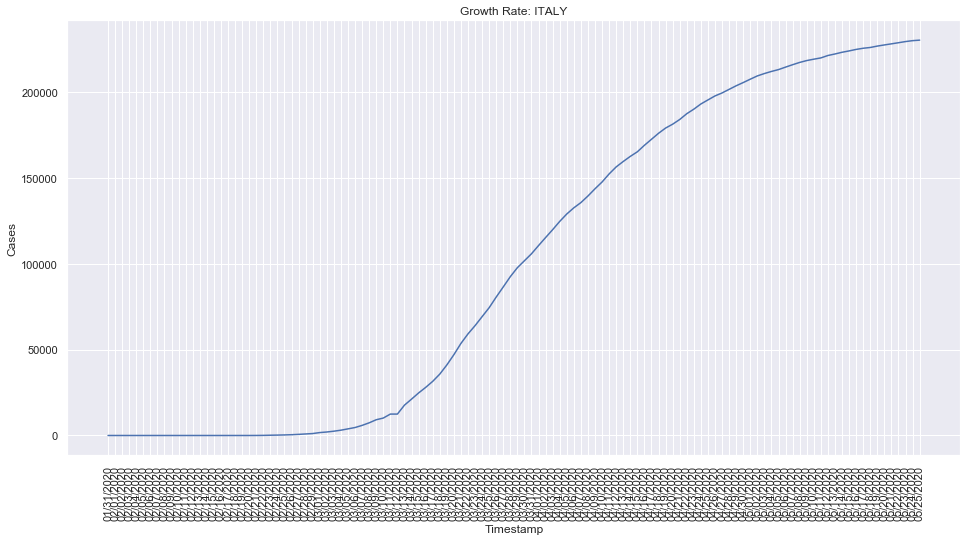

In [141]:
# Plot growth rate for an Area of Interest
area_of_interest = 'italy'
y_data = country_date_scores.loc[country_date_scores.country == area_of_interest, 'confirmed']
x_data = country_date_scores.loc[country_date_scores.country == area_of_interest, 'observation_date']

plt.subplots(1, 1, figsize=(16, 8))
plt.plot(x_data, y_data)
plt.xlabel("Timestamp")
plt.ylabel("Cases")
plt.title(f"Growth Rate: {area_of_interest.upper()}")
plt.xticks(rotation=90)
plt.show()

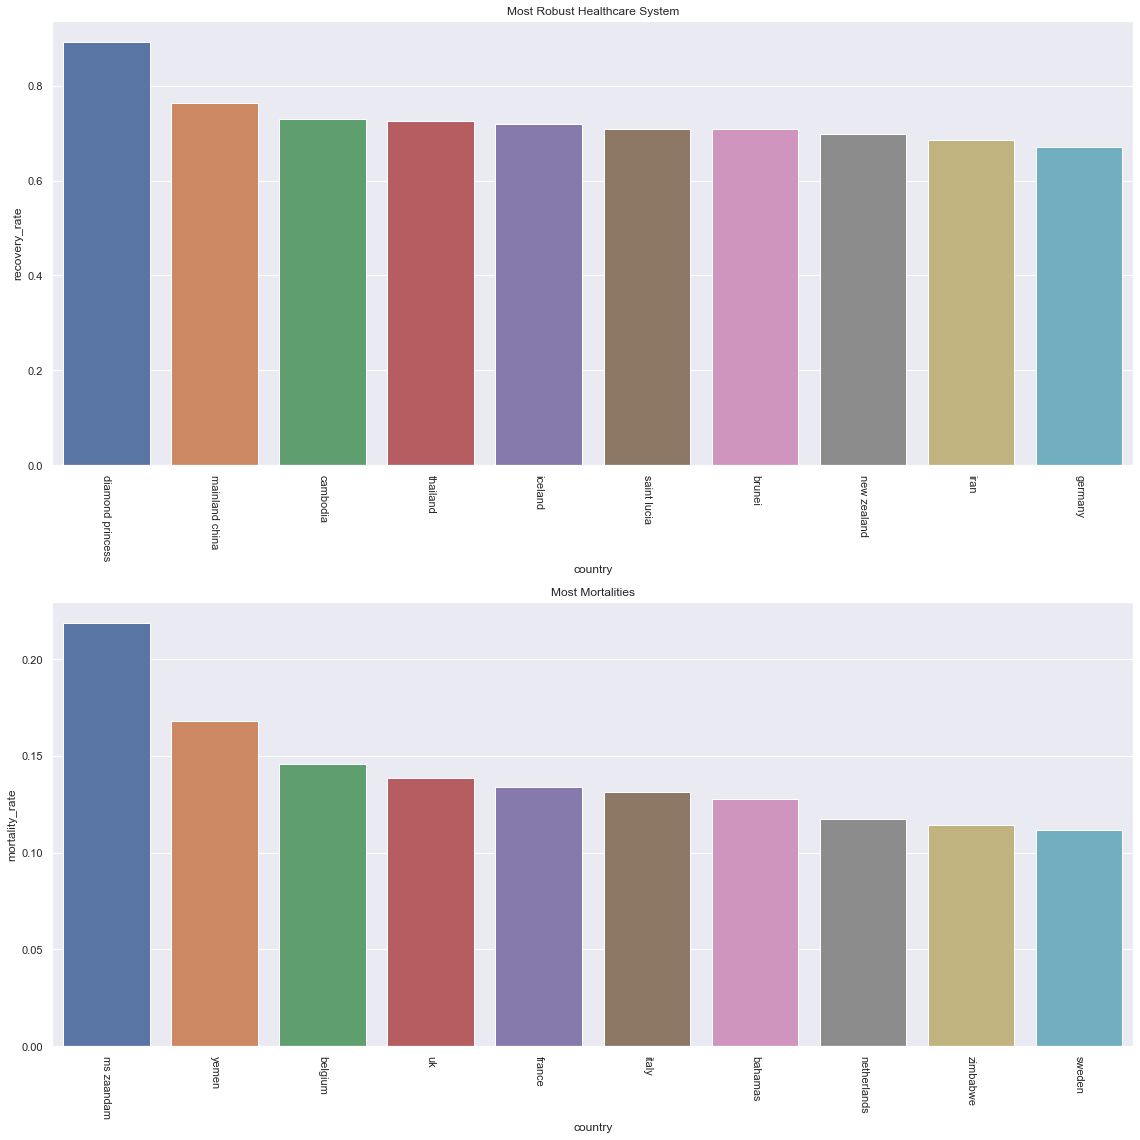

In [142]:
# Most robust healthcare system
# Most mortalities
# There is an issue here, find it

group_country_scores = country_scores.groupby(by=['country']).agg({'confirmed': 'sum', 'deaths': 'sum', 'recovered': 'sum'})
group_country_scores['recovery_rate'] = group_country_scores['recovered'] / group_country_scores['confirmed']
group_country_scores['mortality_rate'] = group_country_scores['deaths'] / group_country_scores['confirmed']

fig, axes = plt.subplots(2, 1, figsize=(16, 16))

recovery_df = group_country_scores.loc[group_country_scores['confirmed'] > 100, ['recovery_rate']].sort_values(by=['recovery_rate'], ascending=False).head(10)
sns.barplot(x=recovery_df.index, y="recovery_rate", data=recovery_df, ax=axes[0])
axes[0].set_title("Most Robust Healthcare System")
axes[0].xaxis.set_tick_params(rotation=270)

mortality_df = group_country_scores.loc[group_country_scores['confirmed'] > 100, ['mortality_rate']].sort_values(by=['mortality_rate'], ascending=False).head(10)
sns.barplot(x=mortality_df.index, y="mortality_rate", data=mortality_df, ax=axes[1])
axes[1].set_title("Most Mortalities")
axes[1].xaxis.set_tick_params(rotation=270)

fig.tight_layout()
plt.show()

In [143]:
# Check if confirmed cases are greater or equal to the sum of death and recovered cases combined
country_date_scores['check_sum'] = country_date_scores.apply(lambda x: True if x['confirmed'] >= (x['deaths'] + x['recovered']) else False, axis=1)
print(np.sum(~country_date_scores['check_sum'])) # we check all cells contain True value or not, if result is 0, that's what we want
country_date_scores.drop(['check_sum'], axis=1, inplace=True)

0


In [144]:
# Convert observation_date to pandas datetime format for further processing
# country_date_scores['observation_date'] = pd.to_datetime(country_date_scores['observation_date'])
country_date_scores['observation_date'] = country_date_scores['observation_date'].map(pd.to_datetime)

In [145]:
date_scores = country_date_scores.groupby(by=['observation_date']).agg({'confirmed': 'sum', 'deaths': 'sum', 'recovered': 'sum'}).reset_index()

In [146]:
# Calculate days_since
date_scores['days_since'] = (date_scores['observation_date'] - date_scores['observation_date'].min()).dt.days

In [147]:
# Check if days_since increases monotonically
assert np.sum(np.diff(date_scores['days_since']) < 0) == 0

In [148]:
# Check if there exists a gap in days_since
last_day = date_scores.iloc[-1]['days_since']
assert date_scores['days_since'].sum() == 0.5 * last_day * (last_day + 1)

In [149]:
# Calculate infected/active cases
date_scores['infected'] = date_scores['confirmed'] - (date_scores['recovered'] + date_scores['deaths'])

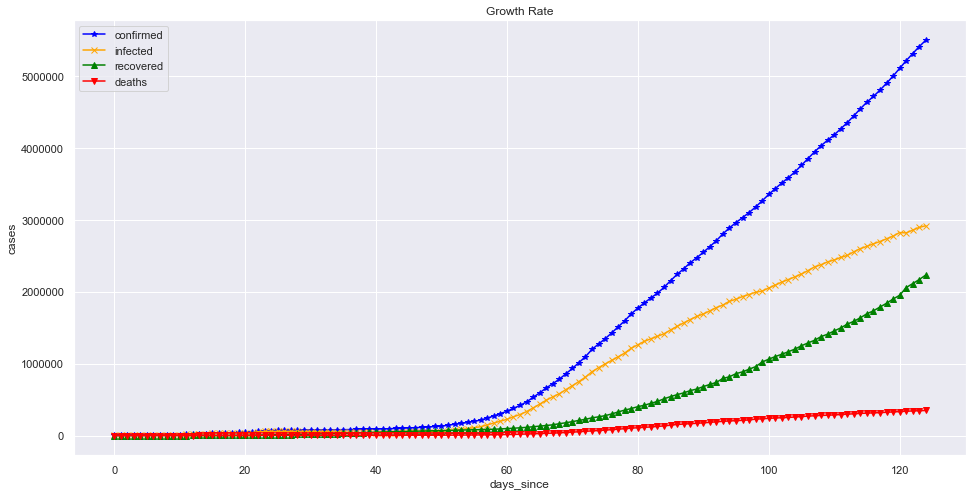

In [150]:
plt.subplots(1, 1, figsize=(16, 8))
plt.plot(date_scores['days_since'], date_scores['confirmed'], label='confirmed', marker='*', color='blue')
plt.plot(date_scores['days_since'], date_scores['infected'], label='infected', marker='x', color='orange')
plt.plot(date_scores['days_since'], date_scores['recovered'], label='recovered', marker='^', color='green')
plt.plot(date_scores['days_since'], date_scores['deaths'], label='deaths', marker='v', color='red')
plt.xlabel("days_since")
plt.ylabel("cases")
plt.title("Growth Rate")
plt.legend(loc='upper left')

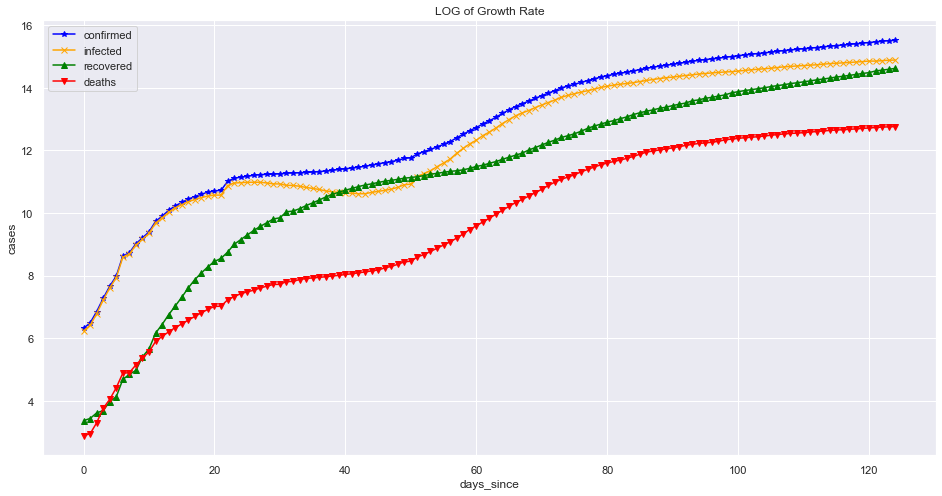

In [151]:
# Better idea?
# Linearization of curves may help to get better performance over the exponential segment
# If you are doing this, make sure that you also inverse the log function when predicting
plt.subplots(1, 1, figsize=(16, 8))
plt.plot(date_scores['days_since'], np.log1p(date_scores['confirmed']), label='confirmed', marker='*', color='blue')
plt.plot(date_scores['days_since'], np.log1p(date_scores['infected']), label='infected', marker='x', color='orange')
plt.plot(date_scores['days_since'], np.log1p(date_scores['recovered']), label='recovered', marker='^', color='green')
plt.plot(date_scores['days_since'], np.log1p(date_scores['deaths']), label='deaths', marker='v', color='red')
plt.xlabel("days_since")
plt.ylabel("cases")
plt.title("LOG of Growth Rate")
plt.legend(loc='upper left')

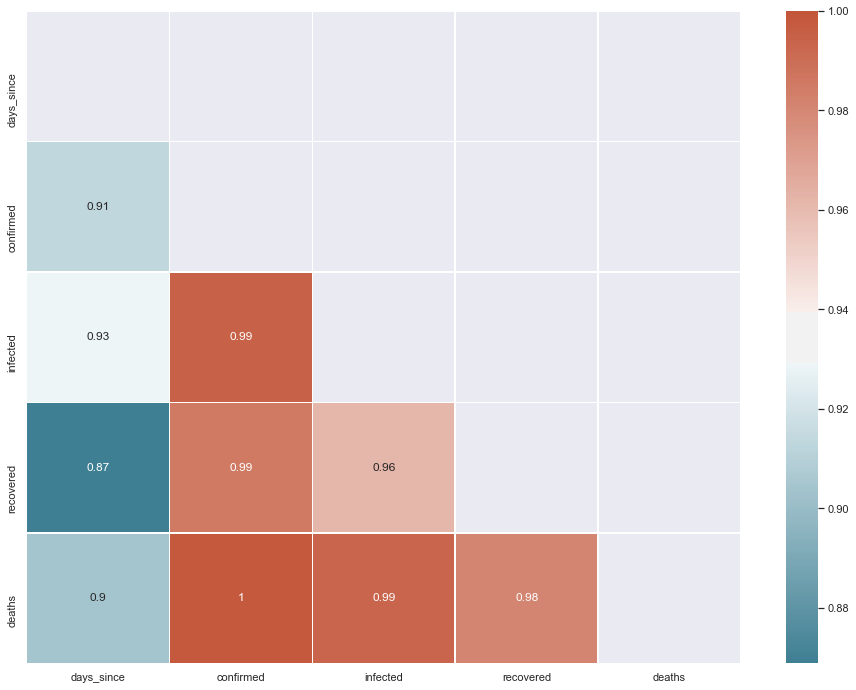

In [152]:
# Correlations

# Set up figure
fig, ax = plt.subplots(figsize=(16, 12))

# Create correlation dataframe
df_corr = date_scores[['days_since', 'confirmed', 'infected', 'recovered', 'deaths']]

# Create correlation matrix
corr = df_corr.corr()

# # Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)

# Plot correlation matrix without the diagonal and upper part
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, linewidths=.5)

## Modeling

In [153]:
date_scores.head()

,observation_date,confirmed,deaths,recovered,days_since,infected
0,2020-01-22,554.0,17.0,28.0,0,509.0
1,2020-01-23,654.0,18.0,30.0,1,606.0
2,2020-01-24,941.0,26.0,36.0,2,879.0
3,2020-01-25,1438.0,42.0,39.0,3,1357.0
4,2020-01-26,2118.0,56.0,52.0,4,2010.0


In [154]:
# Train/Test Split

# train + validation interval: '2020-01-22':'2020-03-09'
# test interval:  '2020-03-10':'2020-03-16'

X_columns = ['days_since', 'observation_date']

# Change y_column to one of ('confirmed', 'infected', 'recovered', 'deaths')
# and re-run this cell and cells below
y_column = ['confirmed'] 
    
X_train = date_scores.loc[date_scores['observation_date'] < '2020-03-10', X_columns]
X_test = date_scores.loc[date_scores['observation_date'] >= '2020-03-10', X_columns]
y_train = date_scores.loc[date_scores['observation_date'] < '2020-03-10', y_column]
y_test = date_scores.loc[date_scores['observation_date'] >= '2020-03-10', y_column]

## XGBoost

In [155]:
import xgboost as xgb

In [156]:
date_scores.head()

,observation_date,confirmed,deaths,recovered,days_since,infected
0,2020-01-22,554.0,17.0,28.0,0,509.0
1,2020-01-23,654.0,18.0,30.0,1,606.0
2,2020-01-24,941.0,26.0,36.0,2,879.0
3,2020-01-25,1438.0,42.0,39.0,3,1357.0
4,2020-01-26,2118.0,56.0,52.0,4,2010.0


In [157]:
# # Scaling
# from sklearn.preprocessing import MinMaxScaler
# sc_X = StandardScaler()
# X_train = sc_X.fit_transform(X_train)
# X_test = sc_X.transform(X_test)

In [158]:
# Train/Test Split

# train + validation interval: '2020-01-22':'2020-03-09'
# test interval:  '2020-03-10':'2020-03-16'

X_columns = ['days_since']

# Change y_column to one of ('confirmed', 'infected', 'recovered', 'deaths')
# and re-run this cell and cells below
y_column = ['confirmed'] 
    
X_train = date_scores.loc[date_scores['observation_date'] < '2020-05-01', X_columns]
X_test = date_scores.loc[date_scores['observation_date'] >= '2020-05-01', X_columns]
y_train = date_scores.loc[date_scores['observation_date'] < '2020-05-01', y_column]
y_test = date_scores.loc[date_scores['observation_date'] >= '2020-05-01', y_column]

In [159]:
date_scores['observation_date']

0     2020-01-22
1     2020-01-23
2     2020-01-24
3     2020-01-25
4     2020-01-26
5     2020-01-27
6     2020-01-28
7     2020-01-29
8     2020-01-30
9     2020-01-31
10    2020-02-01
11    2020-02-02
12    2020-02-03
13    2020-02-04
14    2020-02-05
15    2020-02-06
16    2020-02-07
17    2020-02-08
18    2020-02-09
19    2020-02-10
20    2020-02-11
21    2020-02-12
22    2020-02-13
23    2020-02-14
24    2020-02-15
25    2020-02-16
26    2020-02-17
27    2020-02-18
28    2020-02-19
29    2020-02-20
30    2020-02-21
31    2020-02-22
32    2020-02-23
33    2020-02-24
34    2020-02-25
35    2020-02-26
36    2020-02-27
37    2020-02-28
38    2020-02-29
39    2020-03-01
40    2020-03-02
41    2020-03-03
42    2020-03-04
43    2020-03-05
44    2020-03-06
45    2020-03-07
46    2020-03-08
47    2020-03-09
48    2020-03-10
49    2020-03-11
50    2020-03-12
51    2020-03-13
52    2020-03-14
53    2020-03-15
54    2020-03-16
55    2020-03-17
56    2020-03-18
57    2020-03-19
58    2020-03-

In [160]:
DM_train = xgb.DMatrix(data=X_train, label=y_train)
DM_test = xgb.DMatrix(data=X_test, label=y_test)

In [161]:
from xgboost import XGBRegressor

In [162]:
xgb_model = XGBRegressor().fit(X_train, y_train)

In [163]:
y_pred = xgb_model.predict(X_test)

In [164]:
np.sqrt(mean_squared_error(y_test, y_pred))

1292776.6481474293

In [95]:
xgb_grid = {
    'colsample_bytree':[0.2,0.4,0.6,0.8,0.9,1],
    'n_estimators':[100,200,400,500,1000],
    'max_depth':[2,3,4,5,6,7,8],
    'learning_rate':[0.1,0.01,0.05,0.5]
}

In [96]:
xgb = XGBRegressor()

xgb_cv = GridSearchCV(xgb,
                     param_grid = xgb_grid,
#                      cv=10,
                     n_jobs=-1,
                     verbose=2,
                     cv=[(slice(0, 35), slice(35, 48))],
                         scoring={"mse": make_scorer(mean_squared_error, greater_is_better=False), 
                                  "mae": make_scorer(mean_absolute_error, greater_is_better=False), 
                                  "r2": make_scorer(r2_score, greater_is_better=True)},
                         refit="mse",
                         return_train_score=True)

xgb_cv.fit(X_train, y_train)


Fitting 1 folds for each of 840 candidates, totalling 840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 220 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 626 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 840 out of 840 | elapsed:   28.6s finished


GridSearchCV(cv=[(slice(0, 35, None), slice(35, 48, None))], error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=n...
             param_grid={'colsample_bytree': [0.2, 0.4, 0.6, 0.8, 0.9, 1],
                         'learning_rate': [0.1, 0.01, 0.05, 0.5],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8],
                         'n_estimators': [100, 200, 400, 500, 1000]},
             pre_dispatch='2*n_jobs', refit='mse', re

In [172]:
xgb_cv_results = xgb_cv.cv_results_

In [173]:
xgb_cv_results.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_colsample_bytree', 'param_learning_rate', 'param_max_depth', 'param_n_estimators', 'params', 'split0_test_mse', 'mean_test_mse', 'std_test_mse', 'rank_test_mse', 'split0_train_mse', 'mean_train_mse', 'std_train_mse', 'split0_test_mae', 'mean_test_mae', 'std_test_mae', 'rank_test_mae', 'split0_train_mae', 'mean_train_mae', 'std_train_mae', 'split0_test_r2', 'mean_test_r2', 'std_test_r2', 'rank_test_r2', 'split0_train_r2', 'mean_train_r2', 'std_train_r2'])

In [174]:
xgb_cv.best_params_

{'colsample_bytree': 0.2,
 'learning_rate': 0.5,
 'max_depth': 3,
 'n_estimators': 400}

In [184]:
xgb_tuned = XGBRegressor(colsample_bytree = 1,
                         learning_rate = 0.8,
                         max_depth = 3,
                         n_estimators = 200)

xgb_tuned = xgb_tuned.fit(X_train, y_train)

In [185]:
y_pred = xgb_tuned.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

1292664.171986433

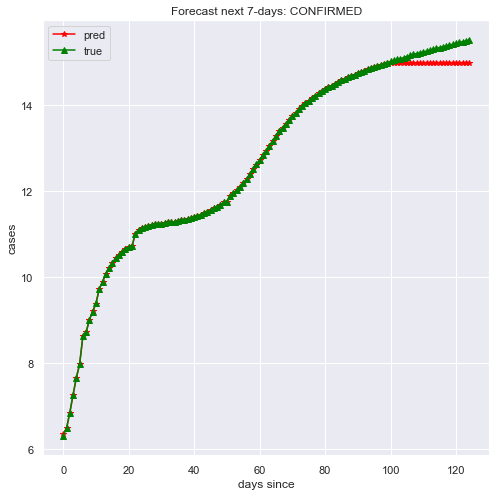

Scores:
------- 

Train MSE: 0.0003403212342943464
Train MAE: 0.016768973214285714
Train R2: 0.9999999999996148


Val MSE: 304363903.4784264
Val MAE: 14184.469350961539
Val R2: 1.95027084821545


Test MSE: 1670945924620.36
Test MAE: 1120537.96
Test MAPE: 23.91 %
Test R2: -3.0230738464565334


In [191]:
results = pd.DataFrame()
results['y_pred'] = xgb_tuned.predict(date_scores[X_columns])
results['y_true'] = date_scores[y_column]

plt.subplots(1, 1, figsize=(8, 8))
plt.plot(np.log1p(results['y_pred']), marker='*', color='red', label="pred")
plt.plot(np.log1p(results['y_true']), marker='^', color='green', label="true")
plt.xlabel("days since")
plt.ylabel("cases")
plt.title(f"Forecast next 7-days: {y_column[0].upper()}")
plt.legend()
plt.show()

best_score_index = np.where(xgb_cv_results['rank_test_mse'] == xgb_cv_results['rank_test_mse'].min())[0][0]

print("Scores:")
print("-"*7, "\n")
print(f"Train MSE: {np.abs(xgb_cv_results['mean_train_mse'][best_score_index])}") 
print(f"Train MAE: {np.abs(xgb_cv_results['mean_train_mae'][best_score_index])}")
print(f"Train R2: {np.abs(xgb_cv_results['mean_train_r2'][best_score_index])}")
print('\n')
print(f"Val MSE: {np.abs(xgb_cv_results['mean_test_mse'][best_score_index])}") 
print(f"Val MAE: {np.abs(xgb_cv_results['mean_test_mae'][best_score_index])}")
print(f"Val R2: {np.abs(xgb_cv_results['mean_test_r2'][best_score_index])}")
print('\n')
print(f"Test MSE: {mean_squared_error(test_scores['y_true'], test_scores['y_pred'])}")
print(f"Test MAE: {mean_absolute_error(test_scores['y_true'], test_scores['y_pred'])}")
print(f"Test MAPE: {np.around(np.mean(np.abs(test_scores['y_true'] - test_scores['y_pred'])/test_scores['y_true'])*100.0, 2)} %")
print(f"Test R2: {r2_score(test_scores['y_true'], test_scores['y_pred'])}")

## LightGBM

In [75]:
from lightgbm import LGBMRegressor

In [592]:
# !python -m pip install lightgbm

You should consider upgrading via the 'C:\Python\Python38\python.exe -m pip install --upgrade pip' command.


In [76]:
lgbm = LGBMRegressor()
lgbm_model = lgbm.fit(X_train, y_train)

In [77]:
y_pred = lgbm_model.predict(X_test, 
                            num_iteration = lgbm_model.best_iteration_)

In [78]:
np.sqrt(mean_squared_error(y_test, y_pred))

2011769.7326853937

In [79]:
lgbm_grid = {
    'colsample_bytree': [0.4, 0.5,0.6,0.9,1],
    'learning_rate': [0.01, 0.1, 0.5,1],
    'n_estimators': [20, 40, 100, 200, 500,1000],
    'max_depth': [1,2,3,4,5,6,7,8] }

lgbm = LGBMRegressor()
lgbm_cv_model = GridSearchCV(lgbm, lgbm_grid, cv=10, n_jobs = -1, verbose = 2)

In [80]:
lgbm_cv_model.fit(X_train, y_train)

Fitting 10 folds for each of 960 candidates, totalling 9600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 1316 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 2448 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 3908 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 5688 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 7796 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 9600 out of 9600 | elapsed:  3.8min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bytree': [0.4, 0.5, 0.6, 0.9, 1],
                         'learning_rate': [0.01, 0.1, 0.5, 1],
                         'max_depth': [1, 2, 3, 

In [221]:
lgbm_cv_results = lgbm_cv_model.cv_results_
lgbm_cv_results

{'mean_fit_time': array([0.02190125, 0.0238013 , 0.03250182, 0.04630265, 0.10460603,
        0.1653095 , 0.01770108, 0.02080114, 0.03110182, 0.05180297,
        0.10370595, 0.19071085, 0.01960104, 0.02220123, 0.03660209,
        0.05310304, 0.1104063 , 0.19881136, 0.01780093, 0.02240129,
        0.03310192, 0.05640323, 0.10780618, 0.20961196, 0.01780097,
        0.02460144, 0.03540206, 0.05470309, 0.11360643, 0.20781178,
        0.01900105, 0.0219013 , 0.05780327, 0.06680384, 0.1130065 ,
        0.21101208, 0.01880119, 0.02180119, 0.03400204, 0.05540314,
        0.11030629, 0.22001255, 0.02930167, 0.0235014 , 0.04010229,
        0.06780388, 0.11660664, 0.2387136 , 0.01590085, 0.0219012 ,
        0.02800162, 0.04270241, 0.0914053 , 0.16010919, 0.01640086,
        0.02180126, 0.03110178, 0.05480316, 0.10800626, 0.20261164,
        0.01600091, 0.02060113, 0.0318018 , 0.05230298, 0.10580604,
        0.20221148, 0.01630099, 0.02070117, 0.03250179, 0.05410306,
        0.10580599, 0.20491173,

In [216]:
lgbm_cv_results.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_colsample_bytree', 'param_learning_rate', 'param_max_depth', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [222]:
lgbm_cv_model.best_params_

{'colsample_bytree': 0.4,
 'learning_rate': 1,
 'max_depth': 3,
 'n_estimators': 20}

In [223]:
lgbm_tuned = LGBMRegressor(learning_rate = 0.5, 
                           max_depth = 3, 
                           n_estimators = 20,
                           colsample_bytree = 0.4)

lgbm_tuned = lgbm_tuned.fit(X_train,y_train)

In [224]:
y_pred = lgbm_tuned.predict(X_test)

In [225]:
np.sqrt(mean_squared_error(y_test, y_pred))

2025881.0926780053

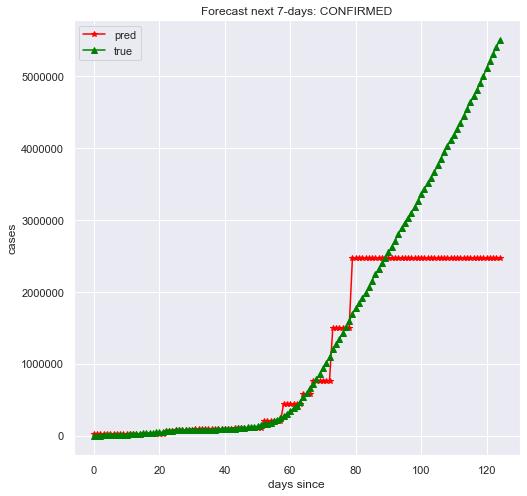

Scores:
------- 



Val MSE: 20.35154400686315


Test MSE: 1670945924620.36
Test MAE: 1120537.96
Test MAPE: 23.91 %
Test R2: -3.0230738464565334


In [226]:
results = pd.DataFrame()
results['y_pred'] = lgbm_tuned.predict(date_scores[X_columns]).flatten()
results['y_true'] = date_scores[y_column]

plt.subplots(1, 1, figsize=(8, 8))
plt.plot((results['y_pred']), marker='*', color='red', label="pred")
plt.plot((results['y_true']), marker='^', color='green', label="true")
plt.xlabel("days since")
plt.ylabel("cases")
plt.title(f"Forecast next 7-days: {y_column[0].upper()}")
plt.legend()
plt.show()

best_score_index = np.where(lgbm_cv_results['rank_test_score'] == lgbm_cv_results['rank_test_score'].min())[0][0]

print("Scores:")
print("-"*7, "\n")
# print(f"Train MSE: {np.abs(lgbm_cv_results['mean_train_mse'][best_score_index])}") 
# print(f"Train MAE: {np.abs(lgbm_cv_results['mean_train_mae'][best_score_index])}")
# print(f"Train R2: {np.abs(lgbm_cv_results['mean_train_r2'][best_score_index])}")
print('\n')
print(f"Val MSE: {np.abs(lgbm_cv_results['mean_test_score'][best_score_index])}") 
# print(f"Val MAE: {np.abs(lgbm_cv_results['mean_test_mae'][best_score_index])}")
# print(f"Val R2: {np.abs(lgbm_cv_results['mean_test_r2'][best_score_index])}")
print('\n')
print(f"Test MSE: {mean_squared_error(test_scores['y_true'], test_scores['y_pred'])}")
print(f"Test MAE: {mean_absolute_error(test_scores['y_true'], test_scores['y_pred'])}")
print(f"Test MAPE: {np.around(np.mean(np.abs(test_scores['y_true'] - test_scores['y_pred'])/test_scores['y_true'])*100.0, 2)} %")
print(f"Test R2: {r2_score(test_scores['y_true'], test_scores['y_pred'])}")